## Install dependencies and import packages
First we need to install the libraries we will be using. We will use `numpy` for generic matrix operations and `tensorflow` for deep learning operations such as convolutions, pooling and training (backpropagation).

In [52]:
import sys
!{sys.executable} -m pip install numpy tensorflow wandb

import wandb
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [53]:
from datetime import datetime

date_and_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

wandb_run = wandb.init(
    project="ai-ml-exercise",
    name=f"preprocessing {date_and_time}"
)

## Download the data
We use a digit classification dataset called *MNIST*. This code downloads and loads the images together with their true labels.

In [54]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Define helper functions for logging histograms to WandB
Weights and Biases has built in functions to generate histograms of data. These functions do however upload every sample to the WandB server before creating the histogram. This is useful to create interactive graphs, but if logging data from many samples it is too slow to upload every single sample. Instead we can create a histogram with `numpy` and only upload the bucket edges and the counts. We then create a bar plot in WandB to visualize the count for each bucket.

In [55]:
def log_bar(x, y, title, x_name="x", y_name="y", keep_order=False):
    if keep_order:
        x = [f"{idx}: {x_}" for idx, x_ in enumerate(x)] # Make sure alphabetical sorting works
    table = wandb.Table(
        data=[[x, y] for x, y in zip(x, y)],
        columns=[x_name, y_name]
    )
    wandb.log({title: wandb.plot.bar(table, x_name, y_name, title=title)})


def create_histogram(data, min_value=None, max_value=None, bins=10):
    if min_value is None:
        min_value = data.min()
    if max_value is None:
        max_value = data.max()

    if isinstance(bins, int):
        bin_edges = np.linspace(min_value, max_value, num=bins)
    else:
        bin_edges = bins
        
    numbers, _ = np.histogram(data, bins=bin_edges)
    bin_names = [f"{lower:.1f}-{upper:.1f}" for lower, upper in zip(bin_edges[:-1], bin_edges[1:])]

    return bin_names, numbers

## Visualize the labels
Except from knowing what the training images looks like it is interesting to know how many images of each label type we have. This is important since if we are lacking data from some label, we will not be able to train a network to recognize images with that label.

In [56]:
from collections import Counter

num_images_per_label = Counter(y_train)
x, num_images = zip(*((str(x_), num_) for x_, num_ in sorted(num_images_per_label.items())))
log_bar(x, num_images, "Labels in training data", x_name="Label", y_name="# images")

num_images_per_label = Counter(y_test)
x, num_images = zip(*((str(x_), num_) for x_, num_ in sorted(num_images_per_label.items())))
log_bar(x, num_images, "Labels in test data", x_name="Label", y_name="# images")

## Visualize the training data
To get a feeling for what the data looks like we will plot one of the training images and its corresponding label. We will also plot a histogram over all the values in all the images so that we can see how the intensity in the images is distributed.

Sample 0 is number 5


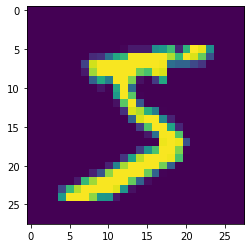

In [57]:
i = 0
print(f"Sample {i} is number {y_train[i]}")
plt.imshow(x_train[0])

image = wandb.Image(x_train[0], caption=f"Training sample {i} is a {y_train[i]}")
wandb.log({"Example training image": image})

In [58]:
# Log the datasets minimum and maximum intensities and datatype to the WandB summary
min_value = min(x_train.min(), x_test.min())
max_value = max(x_train.max(), x_test.max())
wandb_run.summary["raw"] = {"min": min_value, "max": max_value, "dtype": str(x_train.dtype)}

# Create a new histogram of the image pixels intensities
bin_names, train_hist = create_histogram(x_train)
log_bar(bin_names, train_hist, "Raw training data", x_name="bin", y_name="# pixels", keep_order=True)

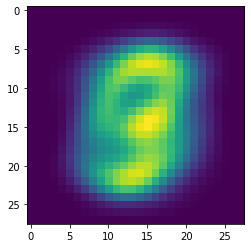

In [59]:
# Create a heatmap over all active pixels from all frames
heatmap = np.mean(x_train, axis=0)
plt.imshow(heatmap)
wandb.log({"Heatmap of training images": wandb.Image(np.expand_dims(heatmap, axis=2), caption="The mean of all images in the training set")})

# Log a histogram of the average value for each pixel through out the
# training dataset. This shows us how many of the pixels that are
# always zero in all frames.
bin_names, heatmap_hist = create_histogram(heatmap.flatten(), bins=[0, 1, 10, 30, 100, 255])
log_bar(bin_names, heatmap_hist, "Average value per pixel in training data", x_name="bin", y_name="# pixels", keep_order=True)

## Preprocess the data
Now that we understand the data we are ready to preprocess the images to make them suitable for training of a deep learning model.

In [60]:
# Normalize the values to the range -1...1
x_train_norm = x_train / 128 - 1
x_test_norm = x_test / 128 - 1

In [62]:
# Create a new histogram of the modified values
min_value = min(x_train_norm.min(), x_test_norm.min())
max_value = max(x_train_norm.max(), x_test_norm.max())
wandb_run.summary["preprocessed"] = {"min": min_value, "max": max_value, "dtype": str(x_train_norm.dtype)}

bin_names, train_hist = create_histogram(x_train_norm)
log_bar(bin_names, train_hist, "Preprocessed training data", x_name="bin", y_name="# pixels", keep_order=True)

Sample 0 is number 5


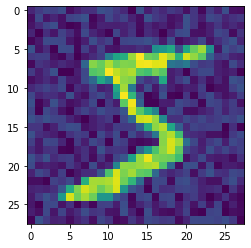

In [63]:
i = 0
print(f"Sample {i} is number {y_train[i]}")
plt.imshow(x_train_norm[0])

image = wandb.Image(x_train_norm[0], caption=f"Training sample {i} is a {y_train[i]}")
wandb.log({"Example training image (preprocessed)": image})

## Subsample the test data set
If the test data set has different number of samples from different labels we will need to weight the different classes differently when evaluating our model if we want each number to be treated as equally importatant. Another option is to subsample so that the test data set has the same number of each label and ignoring the other images.

In [64]:
num_images_per_label = Counter(y_test)
min_number_of_labels = min(num_images_per_label.values())

indexes_to_keep = []
for label in num_images_per_label.keys():
  indexes_to_keep.extend(
      np.random.choice(
          np.where(y_test == label)[0],
          size=min_number_of_labels,
          replace=False
      ).tolist()
  )

np.random.shuffle(indexes_to_keep)
x_test_norm_subsamp = x_test_norm[indexes_to_keep]
y_test_subsamp = y_test[indexes_to_keep]

In [65]:
x_test_norm_subsamp.shape

(8920, 28, 28)

This should be a 5


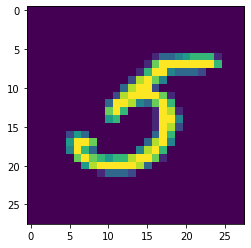

In [66]:
# Verify that the labels and images are still in sync
print(f"This should be a {y_test_subsamp[0]}")
plt.imshow(x_test_norm_subsamp[0])

In [67]:
# Log the new distribution
num_images_per_label = Counter(y_test_subsamp)
labels_, num_images = zip(*((str(label), number) for label, number in sorted(num_images_per_label.items())))
log_bar(labels_, num_images, "Labels in test data (subsampled)", x_name="Label", y_name="# images")